# Pitchfork album reviews clustering
This is very much "in-progress", and mostly a personal learning experience.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sqlalchemy import create_engine
from scipy import sparse
from sklearn.cluster import SpectralClustering

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,7)

Using `sqlachemy`, read tables from the database to Pandas DataFrames.

In [2]:
# read tables from db

engine = create_engine(open('dbinfo.txt', 'r').read().rstrip())

df_reviews = pd.read_sql_table('review', engine)
df_linked_artists = pd.read_sql_table('linkedartist', engine)
df_linked_reviews = pd.read_sql_table('linkedreview', engine)

Query the database with a `JOIN` to find who each artist is linked to, read that into a DataFrame.

In [3]:
# read artist links from db

query_linked_first = """
SELECT Review.artist_url, LinkedArtist.linked_artist_url
FROM Review, LinkedArtist
WHERE Review.id = LinkedArtist.id;
"""
query_linked_second = """
SELECT Review.second_artist_url, LinkedArtist.linked_artist_url
FROM Review, LinkedArtist
WHERE Review.id = LinkedArtist.id
AND Review.second_artist_url IS NOT NULL;
"""
df_artist_links = pd.read_sql_query(query_linked_second, engine)
df_artist_links.rename(columns={'second_artist_url' : 'artist_url'}, inplace=True)
df_artist_links = pd.concat([df_artist_links, pd.read_sql_query(query_linked_first, engine)])

Group the DataFrame by unique identifier `artist_url` to get a Series mapping an artist to all the artists they link to.

In [4]:
# group dataframe by unique artist_urls

artist_links = df_artist_links.groupby('artist_url').aggregate(lambda x: tuple(x))['linked_artist_url']
artist_links[:3]

artist_url
http://pitchfork.com/artists/10008-usher/         (http://pitchfork.com/artists/10008-usher/, ht...
http://pitchfork.com/artists/10015-sam-amidon/    (http://pitchfork.com/artists/10015-sam-amidon...
http://pitchfork.com/artists/1003-damon-naomi/    (http://pitchfork.com/artists/1673-galaxie-500...
Name: linked_artist_url, dtype: object

Use the `df_reviews` DataFrame to get a list of all unique artist urls (including those that don't link to any others).
Note: this only includes artists with full album reviews. Linked artists with artist urls but no album reviews will be ignored.

In [5]:
# get list of all artists

artist_urls = df_reviews[df_reviews['artist_url'].notnull()]['artist_url']
second_artist_urls = df_reviews[df_reviews['second_artist_url'].notnull()]['second_artist_url']
all_artist_urls = artist_urls.append(second_artist_urls)
all_artist_urls_unique = pd.Series(all_artist_urls.unique())

Get a dictionary mapping of artist url to index for building an adjacency matrix.

In [6]:
# get dictionary mapping of artist_url : index

index_to_artist = dict(list(enumerate(all_artist_urls_unique)))
artist_to_index = {v:k for k,v in index_to_artist.items()}

Use the `artist_links` url-to-url mapping to get an index-to-index mapping for the adjacency matrix.

In [7]:
# index to index adjacency mapping

new_index = artist_links.reset_index()['artist_url'].apply(lambda k: artist_to_index[k]).values
index_links = pd.Series(data=artist_links.values, index=new_index)
index_links = index_links.apply(lambda x: tuple(map(lambda k: artist_to_index[k] if k in artist_to_index else None, x)))
index_links[:5]

247     (247, 1714, None, 8410, 5415, 222, 425, None, ...
2122    (2122, 8014, 6949, 1801, 2937, 3560, 1167, Non...
1885                              (4746, 649, 1293, 2057)
1227    (1227, 1227, 1868, 1534, 1215, 4527, 2744, 122...
1565    (3123, 2531, 59, 1759, 3892, 52, 533, None, 25...
dtype: object

Build weighted adjacency matrix `W`, where `W[i,j]` is the number of connections from artist `i` to artist `j`.

In [8]:
# artist adjacency matrix

num_artists = len(artist_to_index)
adj_matrix = np.zeros((num_artists, num_artists))
for idx, val in index_links.iteritems():
    for jdx in val:
        if jdx is not None:
            adj_matrix[idx,jdx] = adj_matrix[idx,jdx] + 1

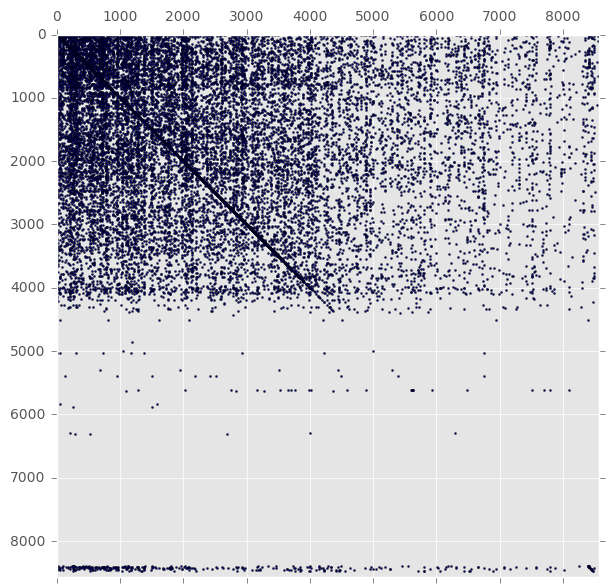

In [9]:
# view sparse adjacency matrix

sparse_adj_matrix = sparse.csr_matrix(adj_matrix)
plt.spy(sparse_adj_matrix, markersize=1)

Pitchfork didn't regularly include links to other artist pages in their reviews until 2011 or so, and the list of artist urls I use here is roughly in reverse chronological order (with the small number of artists who only appear as secondary artists appended to the end). This explains the large unfilled area of the adjacency matrix.

In [10]:
artist_graph = nx.DiGraph(data=adj_matrix)

## END
Below this point is basically a sandbox where I've been playing around with some stuff. I'll clean it up in future commits.

In [ ]:
nx.draw_spring(artist_graph, arrows=True, node_size=1, node_color=clustering.labels_)

In [ ]:
artist_graph.edges(data=True)

In [ ]:
print(index_to_artist[3280])
#list(map(lambda x: index_to_artist[x], artist_graph.neighbors(2278)))

In [ ]:
clustering = SpectralClustering(affinity='precomputed').fit(adj_matrix)

In [ ]:
pd.Series(nx.pagerank(artist_graph)).sort_values(ascending=False).reset_index()['index'].apply(lambda k: index_to_artist[k])
# note: popular artists before 2011 may be disproportionately represented in the pagerank, 
# because they were reviewed before they could link to things
# todo: maybe try this whole thing with only artists after 2011?
# also todo: functions for easy conversion between index -> name for printing

# THE FACT THAT

In [ ]:
artist_graph.get_edge_data(301, 445)

In [ ]:
print(artist_to_index['http://pitchfork.com/artists/11388-terry-riley/'])
print(artist_to_index['http://pitchfork.com/artists/15828-pauline-oliveros/'])

In [ ]:
list(map(lambda x: index_to_artist[x], artist_graph.predecessors(2835)))